https://core.today/notebook/X0U8c3vT4

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

1.12.0+cu113


# GNN으로 노드 분류하기

이번 튜토리얼에서는 **그래프 신경망(GNN)을 노드 분류 작업**에 적용하는 방법을 배웁니다.  
노드 분류를 위해 노드들의 작은 하위 집합(subset)에 대한 정답 레이블(ground-truth label)이 제공되고 나머지 모든 노드에 대한 레이블을 추론하려고 합니다(*변환 학습 transductive learning*).

실험을 위해, 노드가 문서를 나타내는 **인용 네트워크**(citation network)인 `Cora` 데이터셋을 사용하겠습니다.  
각 노드는 1433차원 bag-of-words 특징 벡터로 구성되어 있습니다.  
두 문서 사이에 인용 링크가 있는 경우, 두 문서는 연결됩니다.  
미션은 각 문서의 카테고리를 추론하는 것입니다. (총 7개의 카테고리)

이 데이터셋은 [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) 'Planetoid' 벤치마크 데이터셋 중 하나입니다. 데이터셋은 [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric)의 [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid) 함수를 이용해 쉽게 액세스할 수 있습니다.

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


'Cora' 네트워크는 2,708개의 노드와 10,556개의 엣지를 갖고 있으며 평균 도수(average degree)가 3.9입니다.  
이 데이터셋을 학습하기 위해 140개 노드(각 클래스에 20개)에 대한 정답 데이터가 제공됩니다. 이는 전체 데이터의 약 5%입니다.

이 그래프에는 유효성 검사 및 테스트에 사용해야 하는 노드를 나타내는 `val_mask` 및 `test_mask` 속성이 추가로 포함되어 있습니다.  
또한 pyg의 **`transform=NormalizeFeatures()`**를 이용해 [데이터 변환](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms)을 할 수 있습니다.  
데이터 변환은 입력 데이터를 신경망에 입력하기 전에 수정하는 데 사용할 수 있습니다. 정규화나 데이터 증강(data agmentation) 등을 적용해 볼 수 있습니다.  
이 튜토리얼에서는 입력 특징 벡터 bag-of-words의 [행 정규화](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures)를 적용해 보겠습니다.

그리고 이 네트워크는 비방향성(undirected) 네트워크이고 고립된(isolated) 노드가 존재하지 않습니다. 다시 말해, 모든 문서는 적어도 하나의 인용(엣지)을 갖고 있습니다.

## 다층 퍼셉트론(MLP, Multi-layer Perceptron) 네트워크 학습하기

먼저 관계 정보를 고려하지 않고 바로 MLP로 학습하여 카테고리를 추론해 보겠습니다.  

각 노드의 특징 벡터만 바로 사용해서 구성해 보죠.

In [3]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


지난 튜토리얼 1처럼 학습 없이 그냥 한 번 넣어서 시각화 해보겠습니다.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


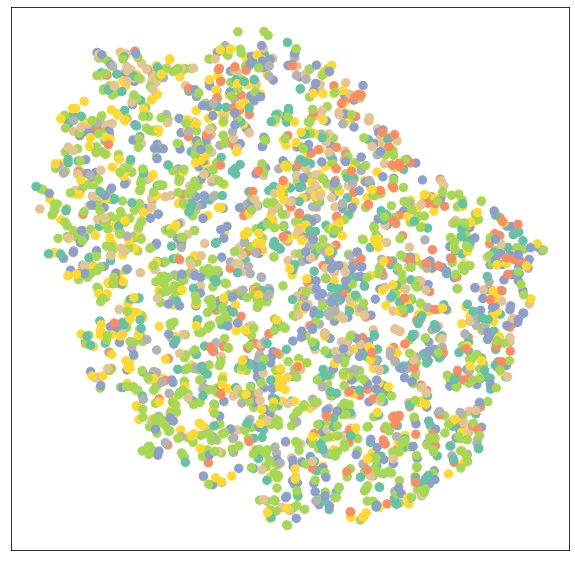

In [4]:
model = MLP(hidden_channels=16)
model.eval()

out = model(data.x)
visualize(out, color=data.y)

위에서 정의한 MLP는 두 개의 선형 레이어로 정의되고 [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU)의 비선형성 [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout)으로 성능이 개선됩니다.  

첫 번째 선형 레이어는 1433차원 특징 벡터를 저차원 임베딩(`hidden_channels=16`)으로 줄이고, 두 번째 선형 레이어는 각 저차원 노드 임베딩을 7가지 클래스 중 하나로 매핑하는 분류기(classifier) 역할을 합니다.

튜토리얼 1에서 수행한 것처럼 **교차 엔트로피 손실(cross entropy loss)**과 **Adam optimizer**를 사용하겠습니다.  
이번에는 최종 모델이 테스트 노드 데이터셋(학습 중에 관찰되지 않은 레이블)에서 얼마나 잘 수행되는지 평가하기 위해 **`test` 함수**도 정의합니다.

In [5]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


학습 결과를 그림으로도 시각화 해보겠습니다

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


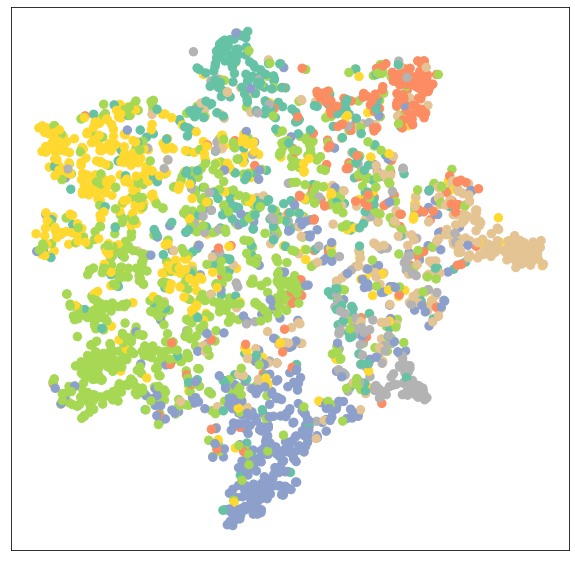

In [6]:
model.eval()

out = model(data.x)
visualize(out, color=data.y)

모델을 훈련시킨 후 `test` 함수를 호출하여 모델이 보이지 않는 레이블에서 얼마나 잘 수행되는지 확인할 수 있습니다.  
여기서 모델의 정확도. 즉, 올바르게 분류된 노드의 비율을 살펴보죠.

In [7]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


보다시피, MLP는 약 59%의 테스트 정확도로 매우 나쁜 성능을 보입니다. MLP가 성능을 발휘하지 못하는 이유는 무엇일까요?  

주된 이유는 이 모델이 **적은 양의 훈련 노드**만 사용했기 때문에 과도한 과적합이 발생하고, 따라서 보이지 않는 노드 표현으로 제대로 일반화되지 않았기 때문입니다.

또한 모델에 중요한 편향(bias)을 반영하지 못했습니다. 예를 들어, **인용된 논문은 해당 문서의 카테고리와 관련이 있을 가능성이 매우 높다**는 부분을 잘 살리지 못했습니다.  
이러한 부분들이 바로 Graph Neural Networks가 잘 작동할 수 있는 부분이며 우리 모델의 성능을 높이는 데 도움이 될 수 있습니다.

## 그래프 신경망(GNN, Graph Neural Networks) 훈련

MLP에서 사용한 'torch.nn.Linear' 레이어를 PyG의 GNN 연산자로 교체하여 MLP를 GNN으로 쉽게 변환할 수 있습니다.

선형 레이어를 튜토리얼 1에서 사용한 [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)를 이용해, **GCN 계층**([Kipf et al.(2017)](https://arxiv.org/abs/1609.02907))으로 표현해 보죠.

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

여기서 $\mathbf{W}^{(\ell + 1)}$는 `[num_output_features, num_input_features]` 모양의 학습 가능한 가중치 행렬을 나타내고 $c_{w,v}$는 각 엣지에 대한 고정 정규화 계수(fixed normalization coefficient)를 나타냅니다.  
대조적으로 단일 `선형` 레이어는 다음과 같이 정의됩니다.

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

선형 레이어에서는 인접 노드 정보를 사용하지 않는 점이 큰 차이점 입니다.

In [8]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


훈련을 시작하기 전에, 먼저 **훈련되지 않은** GCN 네트워크의 노드 임베딩을 시각화해 보겠습니다.  
시각화를 위해 [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)를 사용하여 7차원 노드 임베딩을 2차원으로 사영합니다.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


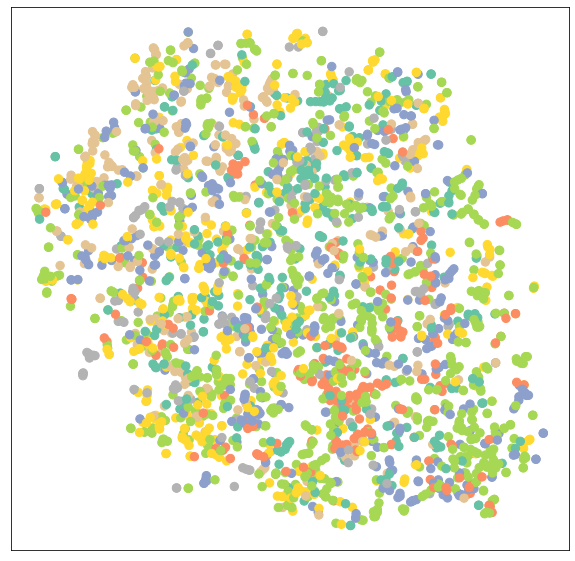

In [9]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

이제 GNN 모델을 학습함으로써 얼마나 더 잘 분류할 수 있는지 해보죠.  
train 함수와 test 함수로 구분지어, 노드 특징 `x`와 그래프 연결 정보 `edge_index`를 GCN 모델에 대한 입력으로 사용합니다.

In [10]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


After training the model, we can check its test accuracy:

In [11]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


놀랍게도 선형 레이어를 GNN 레이어로 교체한 것만으로도 **81.5%의 테스트 정확도**에 도달할 수 있습니다!  
이것은 MLP에서 얻은 59%의 테스트 정확도와 극명한 차이를 말하며, 관계형 정보가 더 나은 성능을 얻는 데 중요한 역할을 한다는 것을 나타냅니다.

또한 학습된 모델의 출력 임베딩을 확인하여 그 성능을 시각화할 수 있습니다. 노드 클러스터링의 성능을 그림으로 그려보죠!

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


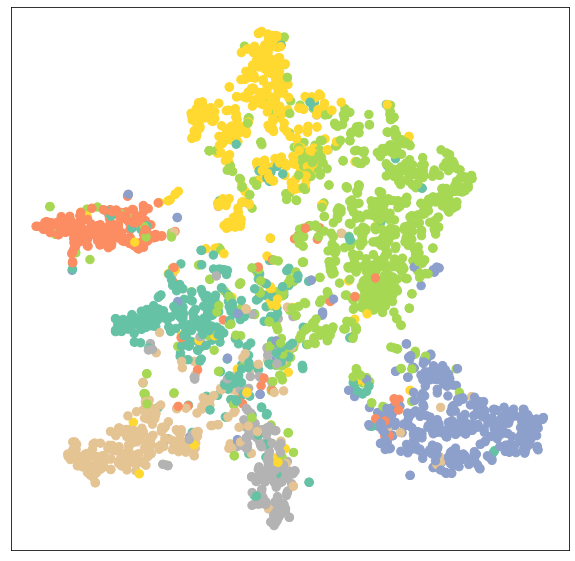

In [12]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## 결론

이번 튜토리얼에서는 학습 데이터와 테스트 데이터로 나뉘어진 데이터셋에 GNN을 적용하는 방법, 특히 모델의 성능을 높이는 데 GNN이 얼마나 효과적일 수 있는지 보였습니다. 기존의 여러 데이터셋에 GNN을 적용해 보세요~!

## 연습문제

1. 더 좋은 성능을 얻고 과적합을 피하기 위해서는 일반적으로 검증(validation) 데이터셋을 추가로 사용합니다.  
`Cora` 데이터셋은 `data.val_mask`로 설정된 유효성 검사 노드를 제공하지만 위에서는 사용하지 않았습니다. 검증 데이터셋을 사용하면 성능이 어떻게 될까요? 직접 한 번 코딩해 보세요! (확실히 성능은 더 개선됩니다!)

2. 은닉층의 특징 차원이나 레이어 수를 늘릴 때 `GCN`은 어떻게 동작할까요? 레이어 수를 늘리는 것이 성능에 도움이 될까요?

3. 다른 GNN 레이어를 사용하여 모델 성능이 어떻게 변하는지 확인할 수 있습니다. 모든 `GCNConv` 인스턴스를 어텐션 메커니즘(Attention mechanism)을 사용하는 [`GATConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv)로 교체해 보세요! 첫 번째 레이어에 8개의 Attention Head와 두 번째 레이어에 1개의 Attention Head를 사용하고 각 'GATConv' 호출 내부와 외부에서 '0.6'의 '드롭아웃' 비율을 사용하는 2계층 'GAT' 모델을 작성해 보세요. 아래 코드에서는 헤드당 '8'의 'hidden_channels' 차원을 사용합니다.

In [13]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(...)  # TODO
        self.conv2 = GATConv(...)  # TODO

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

TypeError: ignored

# 참고문헌
- https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html
- https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX